# Bootstrap confidence intervals
To "pull yourself up by your bootstraps" is a classic idiom meaning that you achieve a difficult task by yourself with no help at all. In statistical inference, you want to know what would happen if you could repeat your data acquisition an infinite number of times. This task is impossible, but can we use only the data we actually have to get close to the same result as an infinitude of experiments? The answer is yes! The technique to do it is aptly called bootstrapping. This chapter will introduce you to this extraordinarily powerful tool.

# 1. Generating bootstrap replicates
## 1.1 Visualizing bootstrap samples
In this exercise, you will generate bootstrap samples from the set of annual rainfall data measured at the Sheffield Weather Station in the UK from 1883 to 2015. The data are stored in the NumPy array `rainfall` in units of millimeters (mm). By graphically displaying the bootstrap samples with an ECDF, you can get a feel for how bootstrap sampling allows probabilistic descriptions of data.

### Instructions:
* Write a `for` loop to acquire `50` bootstrap samples of the rainfall data and plot their ECDF.
    * Use `np.random.choice()` to generate a bootstrap sample from the NumPy array `rainfall`. Be sure that the `size` of the resampled array is `len(rainfall)`.
    * Use the function `ecdf()` that you wrote in the prequel to this course to generate the `x` and `y` values for the ECDF of the bootstrap sample `bs_sample`.
    * Plot the ECDF values. Specify `color='gray'` (to make gray dots) and `alpha=0.1` (to make them semi-transparent, since we are overlaying so many) in addition to the `marker='.'` and `linestyle='none'` keyword arguments.
* Use `ecdf()` to generate `x` and `y` values for the ECDF of the original rainfall data available in the array `rainfall`.
* Plot the ECDF values of the original data.
* Hit 'Submit Answer' to visualize the samples!

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

def ecdf(data):
    return np.sort(data), np.arange(1, len(data)+1) / len(data)

df = pd.read_csv('_datasets/sheffield_weather_station.csv',
            comment='#', delimiter='\s+', na_values='---')

df = df[df.yyyy <= 2015]
rainfall = df.groupby('yyyy')['rain'].sum().values
np.random.seed(42)

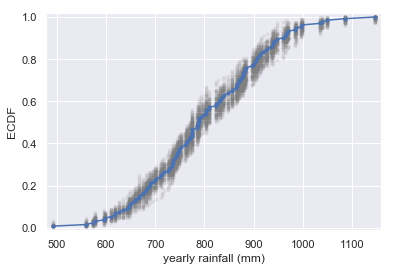

In [2]:
for i in range(50):
    # Generate bootstrap sample: bs_sample
    bs_sample = np.random.choice(rainfall, size=len(rainfall))

    # Compute and plot ECDF from bootstrap sample
    x, y = ecdf(bs_sample)
    _ = plt.plot(x, y, marker='.', linestyle='none',
                 color='gray', alpha=0.1)

# Compute and plot ECDF from original data
x, y = ecdf(rainfall)
_ = plt.plot(x, y, marker='.')

# Make margins and label axes
plt.margins(0.02)
_ = plt.xlabel('yearly rainfall (mm)')
_ = plt.ylabel('ECDF')

# Show the plot
plt.show()

Notice how the bootstrap samples give an idea of how the distribution of rainfalls is spread.

# 2. Bootstrap confidence intervals
## 2.1 Generating many bootstrap replicates
The function `bootstrap_replicate_1d()` from the video is available in your namespace. Now you'll write another function, `draw_bs_reps(data, func, size=1)`, which generates many bootstrap replicates from the data set. This function will come in handy for you again and again as you compute confidence intervals and later when you do hypothesis tests.

For your reference, the `bootstrap_replicate_1d()` function is provided below:

    def bootstrap_replicate_1d(data, func):
        return func(np.random.choice(data, size=len(data)))
    
### Instructions:
* Define a function with call signature `draw_bs_reps(data, func, size=1)`.
    * Using `np.empty()`, initialize an array called `bs_replicates` of size size to hold all of the bootstrap replicates.
    * Write a `for` loop that ranges over `size` and computes a replicate using `bootstrap_replicate_1d()`. Refer to the exercise description above to see the function signature of `bootstrap_replicate_1d()`. Store the replicate in the appropriate index of `bs_replicates`.
    * Return the array of replicates `bs_replicates`. This has already been done for you.

In [3]:
def bootstrap_replicate_1d(data, func):
    return func(np.random.choice(data, size=len(data)))

def draw_bs_reps(data, func, size=1):
    """Draw bootstrap replicates."""

    # Initialize array of replicates: bs_replicates
    bs_replicates = np.empty(size)

    # Generate replicates
    for i in range(size):
        bs_replicates[i] = bootstrap_replicate_1d(data, func)

    return bs_replicates

## 2.2 Bootstrap replicates of the mean and the SEM
In this exercise, you will compute a bootstrap estimate of the probability density function of the mean annual rainfall at the Sheffield Weather Station. Remember, we are estimating the mean annual rainfall we would get if the Sheffield Weather Station could repeat all of the measurements from 1883 to 2015 over and over again. This is a _probabilistic_ estimate of the mean. You will plot the PDF as a histogram, and you will see that it is Normal.

In fact, it can be shown theoretically that under not-too-restrictive conditions, the value of the mean will always be Normally distributed. (This does not hold in general, just for the mean and a few other statistics.) The standard deviation of this distribution, called the __standard error of the mean__, or SEM, is given by the standard deviation of the data divided by the square root of the number of data points. I.e., for a data set, `sem = np.std(data) / np.sqrt(len(data))`. Using hacker statistics, you get this same result without the need to derive it, but you will verify this result from your bootstrap replicates.

### Instructions:
* Draw `10000` bootstrap replicates of the __mean__ annual rainfall using your `draw_bs_reps()` function and the `rainfall` array. _Hint_: Pass in `np.mean` for `func` to compute the mean.
    * As a reminder, `draw_bs_reps()` accepts 3 arguments: `data`, `func`, and `size`.
* Compute and print the standard error of the mean of `rainfall`.
    * The formula to compute this is `np.std(data) / np.sqrt(len(data))`.
* Compute and print the standard deviation of your bootstrap replicates `bs_replicates`.
* Make a histogram of the replicates using the `normed=True` keyword argument and `50` bins.

10.51054915050619
10.46639354664973


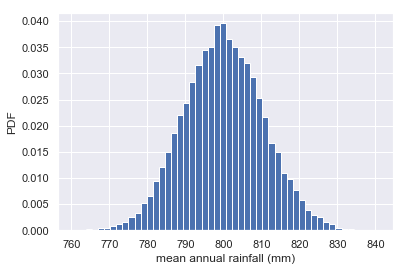

In [4]:
# Take 10,000 bootstrap replicates of the mean: bs_replicates
bs_replicates = draw_bs_reps(rainfall, np.mean, 10000)

# Compute and print SEM
sem = np.std(rainfall) / np.sqrt(len(rainfall))
print(sem)

# Compute and print standard deviation of bootstrap replicates
bs_std = np.std(bs_replicates)
print(bs_std)

# Make a histogram of the results
_ = plt.hist(bs_replicates, bins=50, density=True)
_ = plt.xlabel('mean annual rainfall (mm)')
_ = plt.ylabel('PDF')

# Show the plot
plt.show()

Notice that the SEM we got from the known expression and the bootstrap replicates is the same and the distribution of the bootstrap replicates of the mean is Normal.

## 2.3 Confidence intervals of rainfall data
A _confidence interval_ gives upper and lower bounds on the range of parameter values you might expect to get if we repeat our measurements. For named distributions, you can compute them analytically or look them up, but one of the many beautiful properties of the bootstrap method is that you can take percentiles of your bootstrap replicates to get your confidence interval. Conveniently, you can use the `np.percentile()` function.

Use the bootstrap replicates you just generated to compute the 95% confidence interval. That is, give the 2.5th and 97.5th percentile of your bootstrap replicates stored as `bs_replicates`. What is the 95% confidence interval?

In [5]:
conf_int = np.percentile(bs_replicates, [2.5, 97.5])
print(conf_int)

[779.76992481 820.90345865]


## 2.4 Bootstrap replicates of other statistics
We saw in a previous exercise that the mean is Normally distributed. This does not necessarily hold for other statistics, but no worry: as hackers, we can always take bootstrap replicates! In this exercise, you'll generate bootstrap replicates for the variance of the annual rainfall at the Sheffield Weather Station and plot the histogram of the replicates.

Here, you will make use of the `draw_bs_reps()` function you defined a few exercises ago. It is provided below for your reference:

    def draw_bs_reps(data, func, size=1):
        return np.array([bootstrap_replicate_1d(data, func) for _ in range(size)])
        
Instructions:
* Draw `10000` bootstrap replicates of the __variance__ in annual `rainfall`, stored in the rainfall dataset, using your `draw_bs_reps()` function. _Hint_: Pass in `np.var` for computing the variance.
* Divide your variance replicates (`bs_replicates`) by `100` to put the variance in units of square centimeters for convenience.
* Make a histogram of `bs_replicates` using the `normed=True` keyword argument and `50` bins.

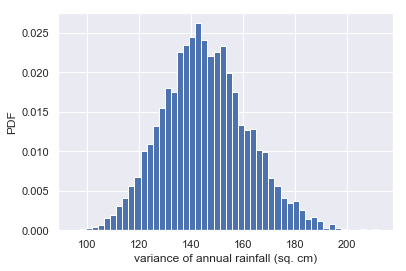

In [6]:
# Generate 10,000 bootstrap replicates of the variance: bs_replicates
bs_replicates = draw_bs_reps(rainfall, np.var, 10000)

# Put the variance in units of square centimeters
bs_replicates = bs_replicates/100

# Make a histogram of the results
_ = plt.hist(bs_replicates, density=True, bins=50)
_ = plt.xlabel('variance of annual rainfall (sq. cm)')
_ = plt.ylabel('PDF')

# Show the plot
plt.show()

This is not normally distributed, as it has a longer tail to the right. Note that you can also compute a confidence interval on the variance, or any other statistic, using `np.percentile()` with your bootstrap replicates.

## 2.5 Confidence interval on the rate of no-hitters
Consider again the inter-no-hitter intervals for the modern era of baseball. Generate 10,000 bootstrap replicates of the optimal parameter $τ$. Plot a histogram of your replicates and report a 95% confidence interval.

### Instructions:
* Generate `10000` bootstrap replicates of τ from the `nohitter_times` data using your `draw_bs_reps()` function. Recall that the the optimal $τ$ is calculated as the `mean` of the data.
* Compute the 95% confidence interval using `np.percentile()` and passing in two arguments: The array `bs_replicates`, and the list of percentiles - in this case `2.5` and `97.5`.
* Print the confidence interval.
* Plot a histogram of your bootstrap replicates.

In [7]:
df = pd.read_csv('_datasets/mlb_nohitters.csv')
t = np.concatenate(((0,), np.diff(df.game_number))).astype(int) - 1
df['time_interval'] = t
nohitter_times = df[df.date>19010000]['time_interval'].values

95% confidence interval = [663.662749   871.55956175] games


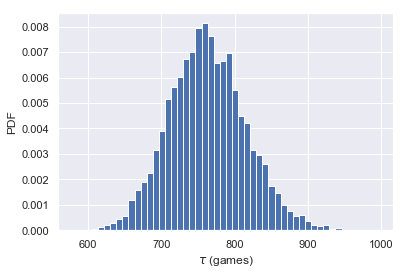

In [8]:
# Draw bootstrap replicates of the mean no-hitter time (equal to tau): bs_replicates
bs_replicates = draw_bs_reps(nohitter_times, np.mean, 10000)

# Compute the 95% confidence interval: conf_int
conf_int = np.percentile(bs_replicates, [2.5, 97.5])

# Print the confidence interval
print('95% confidence interval =', conf_int, 'games')

# Plot the histogram of the replicates
_ = plt.hist(bs_replicates, bins=50, density=True)
_ = plt.xlabel(r'$\tau$ (games)')
_ = plt.ylabel('PDF')

# Show the plot
plt.show()

This gives you an estimate of what the typical time between no-hitters is. It could be anywhere between 660 and 870 games.

# 3. Pairs bootstrap
## 3.1 A function to do pairs bootstrap
As discussed in the video, pairs bootstrap involves resampling pairs of data. Each collection of pairs fit with a line, in this case using `np.polyfit()`. We do this again and again, getting bootstrap replicates of the parameter values. To have a useful tool for doing pairs bootstrap, you will write a function to perform pairs bootstrap on a set of `x,y` data.

### Instructions:
* Define a function with call signature `draw_bs_pairs_linreg(x, y, size=1)` to perform pairs bootstrap estimates on linear regression parameters.
    * Use `np.arange()` to set up an array of indices going from `0` to `len(x)`. These are what you will resample and use them to pick values out of the `x` and `y` arrays.
    * Use `np.empty()` to initialize the slope and intercept replicate arrays to be of size `size`.
    * Write a `for` loop to:
        * Resample the indices `inds`. Use `np.random.choice()` to do this.
        * Make new $x$ and $y$ arrays `bs_x` and `bs_y` using the the resampled indices `bs_inds`. To do this, slice `x` and `y` with `bs_inds`.
        * Use `np.polyfit()` on the new $x$ and $y$ arrays and store the computed slope and intercept.
    * Return the pair bootstrap replicates of the slope and intercept.


In [9]:
def draw_bs_pairs_linreg(x, y, size=1):
    """Perform pairs bootstrap for linear regression."""

    # Set up array of indices to sample from: inds
    inds = np.arange(len(x))

    # Initialize replicates: bs_slope_reps, bs_intercept_reps
    bs_slope_reps = np.empty(size)
    bs_intercept_reps = np.empty(size)

    # Generate replicates
    for i in range(size):
        bs_inds = np.random.choice(inds, size=len(inds))
        bs_x, bs_y = x[bs_inds], y[bs_inds]
        bs_slope_reps[i], bs_intercept_reps[i] = np.polyfit(bs_x, bs_y, 1)

    return bs_slope_reps, bs_intercept_reps

## 3.2 Pairs bootstrap of literacy/fertility data
Using the function you just wrote, perform pairs bootstrap to plot a histogram describing the estimate of the slope from the illiteracy/fertility data. Also report the 95% confidence interval of the slope. The data is available to you in the NumPy arrays `illiteracy` and `fertility`.

As a reminder, `draw_bs_pairs_linreg()` has a function signature of `draw_bs_pairs_linreg(x, y, size=1)`, and it returns two values: `bs_slope_reps` and `bs_intercept_reps`.

### Instructions:
* Use your `draw_bs_pairs_linreg()` function to take `1000` bootstrap replicates of the slope and intercept. The x-axis data is `illiteracy` and y-axis data is `fertility`.
* Compute and print the 95% bootstrap confidence interval for the slope.
* Plot and show a histogram of the slope replicates. Be sure to label your axes. This has been done for you, so click 'Submit Answer' to see your histogram!

In [10]:
df = pd.read_csv('_datasets/female_literacy_fertility.csv')
illiteracy = 100 - df['female literacy'].values
fertility = df['fertility'].values

[0.04445885 0.05540291]


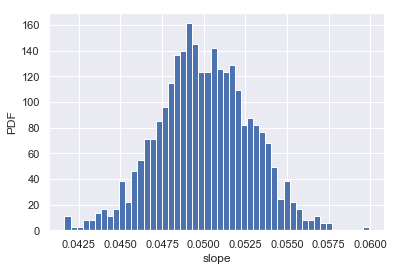

In [11]:
# Generate replicates of slope and intercept using pairs bootstrap
bs_slope_reps, bs_intercept_reps = draw_bs_pairs_linreg(illiteracy, fertility, 1000)

# Compute and print 95% CI for slope
print(np.percentile(bs_slope_reps, [2.5, 97.5]))

# Plot the histogram
_ = plt.hist(bs_slope_reps, bins=50, density=True)
_ = plt.xlabel('slope')
_ = plt.ylabel('PDF')
plt.show()

## 3.3 Plotting bootstrap regressions
A nice way to visualize the variability we might expect in a linear regression is to plot the line you would get from each bootstrap replicate of the slope and intercept. Do this for the first 100 of your bootstrap replicates of the slope and intercept (stored as `bs_slope_reps` and `bs_intercept_reps`).

### Instructions:
* Generate an array of $x$-values consisting of `0` and `100` for the plot of the regression lines. Use the `np.array()` function for this.
* Write a `for` loop in which you plot a regression line with a slope and intercept given by the pairs bootstrap replicates. Do this for `100` lines.
    * When plotting the regression lines in each iteration of the `for` loop, recall the regression equation `y = a*x + b`. Here, a is `bs_slope_reps[i]` and b is `bs_intercept_reps[i]`.
    * Specify the keyword arguments `linewidth=0.5`, `alpha=0.2`, and `color='red'` in your call to `plt.plot()`.
* Make a scatter plot with `illiteracy` on the x-axis and `fertility` on the y-axis. Remember to specify the `marker='.' and `linestyle='none'` keyword arguments.
* Label the axes, set a 2% margin, and show the plot. This has been done for you, so hit 'Submit Answer' to visualize the bootstrap regressions!

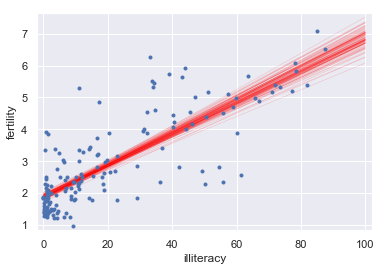

In [12]:
# Generate array of x-values for bootstrap lines: x
x = np.array([0, 100])

# Plot the bootstrap lines
for i in range(100):
    _ = plt.plot(x, 
                 bs_slope_reps[i]*x + bs_intercept_reps[i],
                 linewidth=0.5, alpha=0.2, color='red')

# Plot the data
_ = plt.plot(illiteracy, fertility, marker='.', linestyle='none')

# Label axes, set the margins, and show the plot
_ = plt.xlabel('illiteracy')
_ = plt.ylabel('fertility')
plt.margins(0.02)
plt.show()

You now have some serious chops for parameter estimation. Let's move on to hypothesis testing!